In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from collections import Counter
import json
from tqdm import tqdm

# Setting the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **EDA (Exploratory Data Analysis)**

In [2]:
# Loading the metadata into a dataframe
df = pd.read_csv('/kaggle/input/fashion-product-images-small/styles.csv', on_bad_lines='skip')

# Understanding the metadata dataframe
print(df.head())
print(df.info())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column         

In [3]:
# Cleaning and preparing the Data

# Selecting target columns
df_targets = df[['id', 'gender', 'masterCategory', 'season', 'baseColour']].copy()

# Checking for missing values
print("Missing values per column:\n", df_targets.isnull().sum())

# Dropping rows with any missing values in our target columns
df_targets.dropna(inplace=True)
print(f"\nNumber of rows after dropping NaNs: {len(df_targets)}")

# Adding a column for the image file path
base_path = '/kaggle/input/fashion-product-images-small/images/'
df_targets['image_path'] = df_targets['id'].apply(lambda x: os.path.join(base_path, str(x) + '.jpg'))

# Verifying that the image files actually exist
df_targets['image_exists'] = df_targets['image_path'].apply(os.path.exists)
df_final = df_targets[df_targets['image_exists']].copy()
print(f"Number of rows with existing images: {len(df_final)}")

# Dropping unecessary columns
df_final = df_final.drop(columns=['id', 'image_exists'])
df_final.reset_index(drop=True, inplace=True)

print(df_final.head())

Missing values per column:
 id                 0
gender             0
masterCategory     0
season            21
baseColour        15
dtype: int64

Number of rows after dropping NaNs: 44388
Number of rows with existing images: 44383
  gender masterCategory  season baseColour  \
0    Men        Apparel    Fall  Navy Blue   
1    Men        Apparel  Summer       Blue   
2  Women    Accessories  Winter     Silver   
3    Men        Apparel    Fall      Black   
4    Men        Apparel  Summer       Grey   

                                          image_path  
0  /kaggle/input/fashion-product-images-small/ima...  
1  /kaggle/input/fashion-product-images-small/ima...  
2  /kaggle/input/fashion-product-images-small/ima...  
3  /kaggle/input/fashion-product-images-small/ima...  
4  /kaggle/input/fashion-product-images-small/ima...  


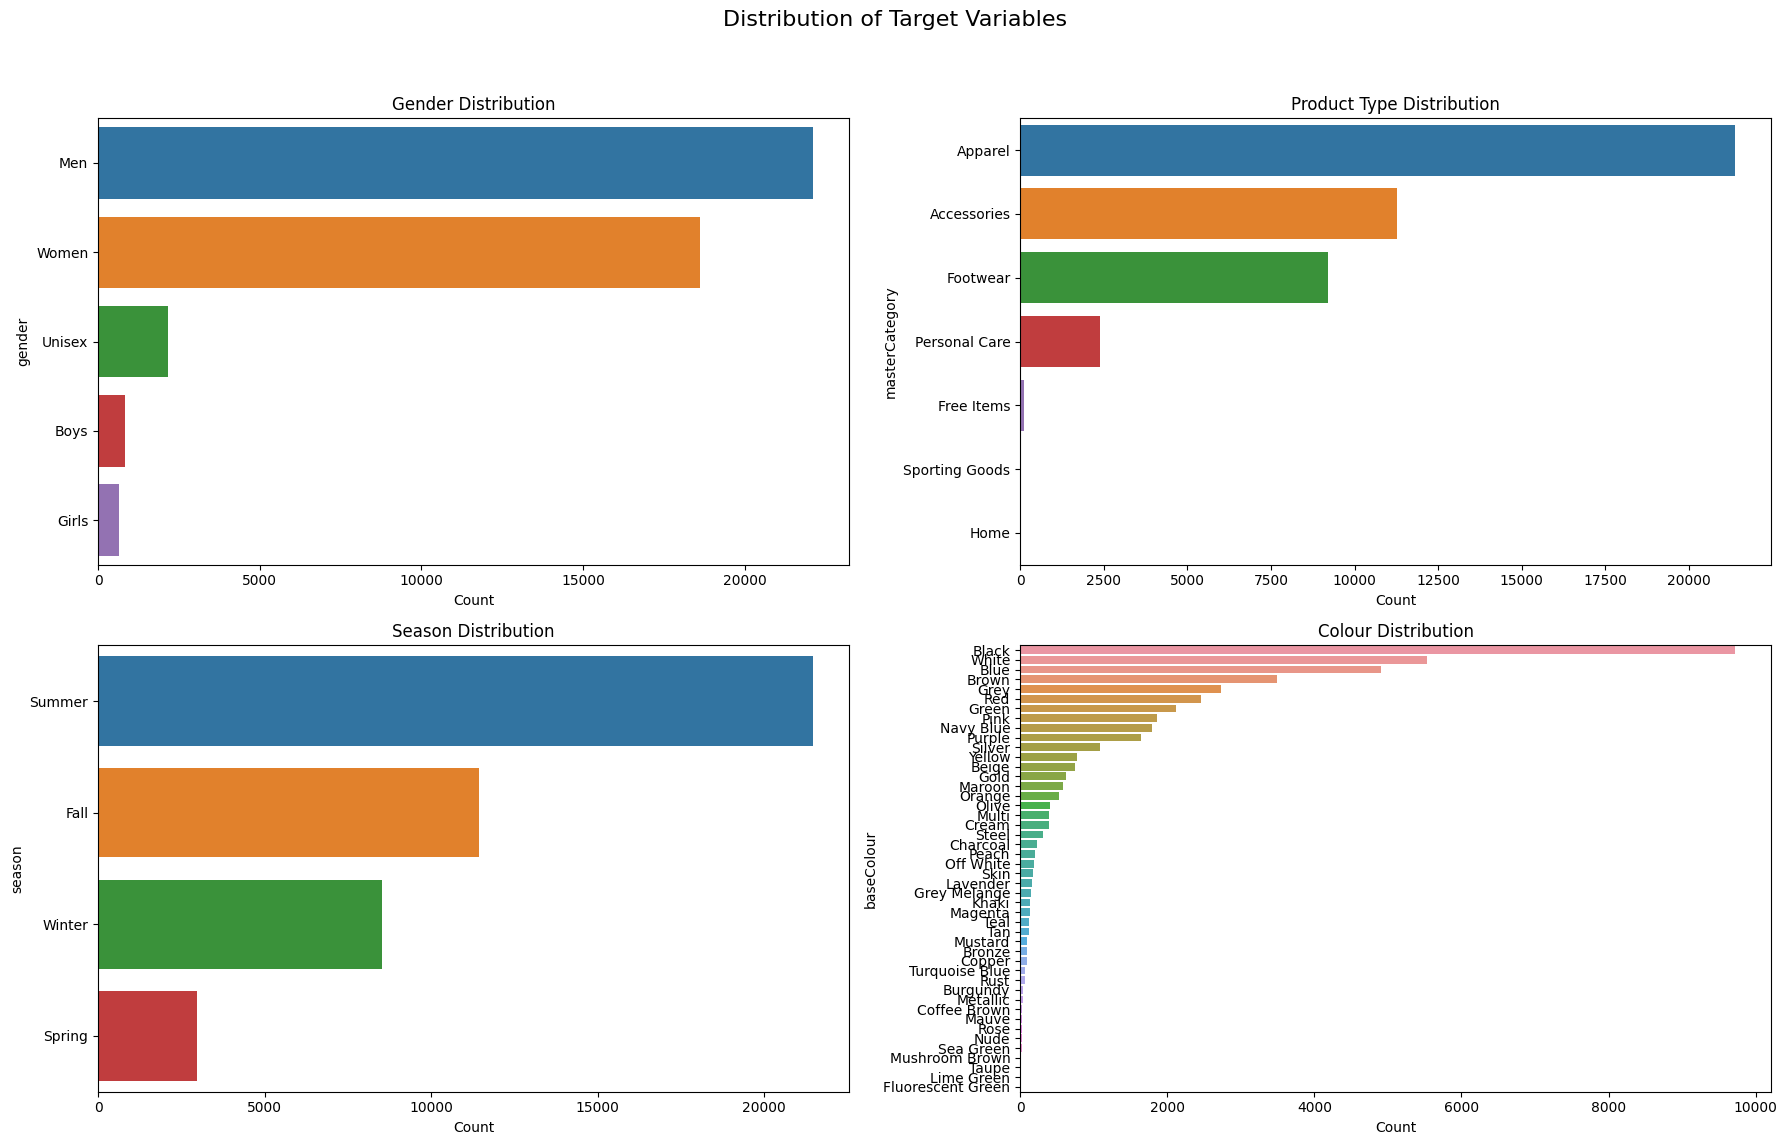

In [4]:
# Analyzing Target Variable Distributions

# Setting up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Distribution of Target Variables', fontsize=16)

# Gender
sns.countplot(ax=axes[0, 0], y=df_final['gender'], order=df_final['gender'].value_counts().index)
axes[0, 0].set_title('Gender Distribution')
axes[0, 0].set_xlabel('Count')

# Master Category
sns.countplot(ax=axes[0, 1], y=df_final['masterCategory'], order=df_final['masterCategory'].value_counts().index)
axes[0, 1].set_title('Product Type Distribution')
axes[0, 1].set_xlabel('Count')

# Season
sns.countplot(ax=axes[1, 0], y=df_final['season'], order=df_final['season'].value_counts().index)
axes[1, 0].set_title('Season Distribution')
axes[1, 0].set_xlabel('Count')

# Base Colour
sns.countplot(ax=axes[1, 1], y=df_final['baseColour'], order=df_final['baseColour'].value_counts().index)
axes[1, 1].set_title('Colour Distribution')
axes[1, 1].set_xlabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

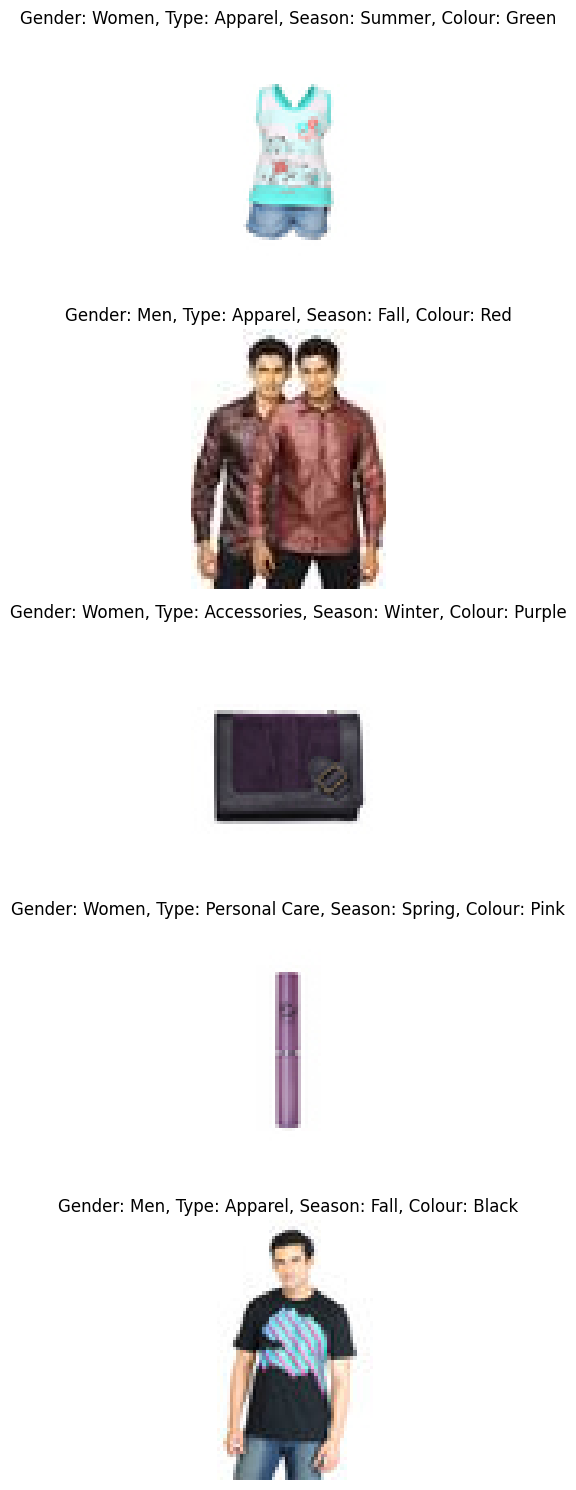

In [5]:
# Visualizing with few sample images before we go ahead
def show_sample_images(df, num_images=5):
    plt.figure(figsize=(15, num_images * 3))
    sample_df = df.sample(num_images)
    for i, (index, row) in enumerate(sample_df.iterrows()):
        img = Image.open(row['image_path'])
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.title(f"Gender: {row['gender']}, Type: {row['masterCategory']}, Season: {row['season']}, Colour: {row['baseColour']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(df_final)

# **Data Preperation for Modeling**

In [6]:
# Encoding Labels

# Initializing encoders and create label mappings
encoders = {}
label_mappings = {}

for col in ['gender', 'masterCategory', 'season', 'baseColour']:
    le = LabelEncoder()
    df_final[f'{col}_encoded'] = le.fit_transform(df_final[col])
    encoders[col] = le
    label_mappings[col] = {i: label for i, label in enumerate(le.classes_)}

# Saving the label mappings for later use in prediction
with open('label_mappings.json', 'w') as f:
    json.dump(label_mappings, f, indent=4)

print("Label Mappings saved to label_mappings.json")
print(df_final.head())

Label Mappings saved to label_mappings.json
  gender masterCategory  season baseColour  \
0    Men        Apparel    Fall  Navy Blue   
1    Men        Apparel  Summer       Blue   
2  Women    Accessories  Winter     Silver   
3    Men        Apparel    Fall      Black   
4    Men        Apparel  Summer       Grey   

                                          image_path  gender_encoded  \
0  /kaggle/input/fashion-product-images-small/ima...               2   
1  /kaggle/input/fashion-product-images-small/ima...               2   
2  /kaggle/input/fashion-product-images-small/ima...               4   
3  /kaggle/input/fashion-product-images-small/ima...               2   
4  /kaggle/input/fashion-product-images-small/ima...               2   

   masterCategory_encoded  season_encoded  baseColour_encoded  
0                       1               0                  25  
1                       1               2                   2  
2                       0               3             

In [7]:
# Splitting Data

# Filtering data to remove classes with only 1 member
class_counts = df_final['masterCategory'].value_counts()

single_member_classes = class_counts[class_counts < 2].index
print(f"Classes with only 1 member: {list(single_member_classes)}")
df_splittable = df_final[~df_final['masterCategory'].isin(single_member_classes)]
print(f"\nOriginal dataframe size: {len(df_final)}")
print(f"Dataframe size after removing rare classes: {len(df_splittable)}")

# Splitting data into Training, Testing and Validation
train_val_df, test_df = train_test_split(df_splittable, test_size=0.2, random_state=42, stratify=df_splittable['masterCategory'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['masterCategory'])

print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Classes with only 1 member: ['Home']

Original dataframe size: 44383
Dataframe size after removing rare classes: 44382

Training set size: 28404
Validation set size: 7101
Test set size: 8877


In [8]:
# This class will load image from it's path and apply transformations and return with it's 4 labels

class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.gender_labels = torch.tensor(self.df['gender_encoded'].values, dtype=torch.long)
        self.type_labels = torch.tensor(self.df['masterCategory_encoded'].values, dtype=torch.long)
        self.season_labels = torch.tensor(self.df['season_encoded'].values, dtype=torch.long)
        self.colour_labels = torch.tensor(self.df['baseColour_encoded'].values, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        labels = {
            'gender': self.gender_labels[idx],
            'masterCategory': self.type_labels[idx],
            'season': self.season_labels[idx],
            'baseColour': self.colour_labels[idx]
        }
        return image, labels

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for the training set with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for validation and testing (No augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FashionDataset(train_df, transform=train_transforms)
val_dataset = FashionDataset(val_df, transform=val_test_transforms)
test_dataset = FashionDataset(test_df, transform=val_test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# Multi-Output Model which uses pre-trained ResNet Model which has 4 heads, each for one prediction task

class MultiOutputFashionModel(nn.Module):
    def __init__(self, num_genders, num_types, num_seasons, num_colours):
        super(MultiOutputFashionModel, self).__init__()

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        num_ftrs = self.backbone.fc.in_features
        
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True

        self.backbone.fc = nn.Identity() 
        self.gender_head = nn.Linear(num_ftrs, num_genders)
        self.type_head = nn.Linear(num_ftrs, num_types)
        self.season_head = nn.Linear(num_ftrs, num_seasons)
        self.colour_head = nn.Linear(num_ftrs, num_colours)

    def forward(self, x):
        features = self.backbone(x)
        gender_out = self.gender_head(features)
        type_out = self.type_head(features)
        season_out = self.season_head(features)
        colour_out = self.colour_head(features)
        
        return {
            'gender': gender_out,
            'masterCategory': type_out,
            'season': season_out,
            'baseColour': colour_out
        }

num_classes = {col: len(label_mappings[col]) for col in label_mappings}
model = MultiOutputFashionModel(
    num_genders=num_classes['gender'],
    num_types=num_classes['masterCategory'],
    num_seasons=num_classes['season'],
    num_colours=num_classes['baseColour']
)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


MultiOutputFashionModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

# **Training the Model**

In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Function to calculate combined loss
def calculate_loss(outputs, labels):
    loss_gender = criterion(outputs['gender'], labels['gender'])
    loss_type = criterion(outputs['masterCategory'], labels['masterCategory'])
    loss_season = criterion(outputs['season'], labels['season'])
    loss_colour = criterion(outputs['baseColour'], labels['baseColour'])
    
    total_loss = loss_gender + loss_type + loss_season + loss_colour
    return total_loss

In [11]:
# Training

NUM_EPOCHS = 10

best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    running_loss = 0.0
    train_loop = tqdm(train_loader, leave=True)
    for images, labels in train_loop:
        images = images.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = calculate_loss(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    val_corrects = {'gender': 0, 'masterCategory': 0, 'season': 0, 'baseColour': 0}
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = {k: v.to(device) for k, v in labels.items()}
            
            outputs = model(images)
            loss = calculate_loss(outputs, labels)
            running_val_loss += loss.item()
            
            for task, out in outputs.items():
                _, preds = torch.max(out, 1)
                val_corrects[task] += torch.sum(preds == labels[task])
            total_samples += images.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracies = {task: 100 * corrects.double() / total_samples for task, corrects in val_corrects.items()}
    scheduler.step()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracies -> Gender: {val_accuracies['gender']:.2f}%, Type: {val_accuracies['masterCategory']:.2f}%, Season: {val_accuracies['season']:.2f}%, Colour: {val_accuracies['baseColour']:.2f}%")

    # Saving the Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_fashion_model.pth')
        print("Model Saved")

print("Finished Training")

Epoch [1/10]: 100%|██████████| 888/888 [06:30<00:00,  2.27it/s, loss=2.75]


Epoch 1/10 -> Train Loss: 2.7495, Val Loss: 2.2068
  Validation Accuracies -> Gender: 88.90%, Type: 98.77%, Season: 70.65%, Colour: 65.20%
Model Saved


Epoch [2/10]: 100%|██████████| 888/888 [04:29<00:00,  3.30it/s, loss=2.26]


Epoch 2/10 -> Train Loss: 2.1324, Val Loss: 2.0839
  Validation Accuracies -> Gender: 90.11%, Type: 98.90%, Season: 73.02%, Colour: 66.16%
Model Saved


Epoch [3/10]: 100%|██████████| 888/888 [04:17<00:00,  3.45it/s, loss=1.49]


Epoch 3/10 -> Train Loss: 1.9176, Val Loss: 2.0153
  Validation Accuracies -> Gender: 91.13%, Type: 98.97%, Season: 72.64%, Colour: 67.88%
Model Saved


Epoch [4/10]: 100%|██████████| 888/888 [04:17<00:00,  3.44it/s, loss=2.01] 


Epoch 4/10 -> Train Loss: 1.5378, Val Loss: 1.8656
  Validation Accuracies -> Gender: 92.13%, Type: 99.20%, Season: 75.57%, Colour: 70.06%
Model Saved


Epoch [5/10]: 100%|██████████| 888/888 [04:33<00:00,  3.25it/s, loss=1.25] 


Epoch 5/10 -> Train Loss: 1.4205, Val Loss: 1.8661
  Validation Accuracies -> Gender: 92.49%, Type: 99.24%, Season: 76.13%, Colour: 69.95%


Epoch [6/10]: 100%|██████████| 888/888 [04:18<00:00,  3.43it/s, loss=1.51] 


Epoch 6/10 -> Train Loss: 1.3505, Val Loss: 1.8680
  Validation Accuracies -> Gender: 92.63%, Type: 99.23%, Season: 76.59%, Colour: 69.79%


Epoch [7/10]: 100%|██████████| 888/888 [04:15<00:00,  3.47it/s, loss=1.21] 


Epoch 7/10 -> Train Loss: 1.2578, Val Loss: 1.8626
  Validation Accuracies -> Gender: 92.69%, Type: 99.21%, Season: 76.37%, Colour: 70.17%
Model Saved


Epoch [8/10]: 100%|██████████| 888/888 [04:18<00:00,  3.44it/s, loss=1.49] 


Epoch 8/10 -> Train Loss: 1.2393, Val Loss: 1.8729
  Validation Accuracies -> Gender: 92.55%, Type: 99.24%, Season: 76.41%, Colour: 70.34%


Epoch [9/10]: 100%|██████████| 888/888 [04:27<00:00,  3.32it/s, loss=1.21] 


Epoch 9/10 -> Train Loss: 1.2318, Val Loss: 1.8684
  Validation Accuracies -> Gender: 92.52%, Type: 99.25%, Season: 76.41%, Colour: 70.16%


Epoch [10/10]: 100%|██████████| 888/888 [04:18<00:00,  3.43it/s, loss=0.89] 


Epoch 10/10 -> Train Loss: 1.2207, Val Loss: 1.8699
  Validation Accuracies -> Gender: 92.62%, Type: 99.25%, Season: 76.57%, Colour: 70.29%
Finished Training


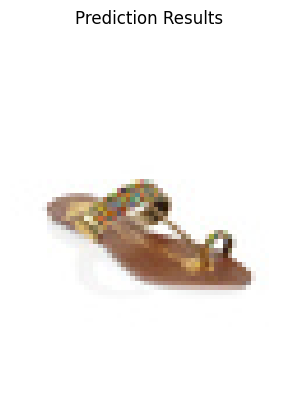

True Labels:
  - Gender: Women
  - Type: Footwear
  - Season: Winter
  - Colour: Multi

Predicted Labels:
  - Gender: Women
  - Type: Footwear
  - Season: Winter
  - Colour: Gold


In [12]:
# Load the saved model
model.load_state_dict(torch.load('best_fashion_model.pth'))
model.eval()

# Load the label mappings we saved earlier
with open('label_mappings.json', 'r') as f:
    label_mappings = json.load(f)

def predict_image(image_path, model, mappings):
    image = Image.open(image_path).convert('RGB')
    transformed_image = data_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(transformed_image)
    
    predictions = {}
    for task, out in outputs.items():
        _, pred_idx = torch.max(out, 1)
        pred_label = mappings[task][str(pred_idx.item())]
        predictions[task] = pred_label
        
    return predictions, image

# Test Image Predictions
sample_row = test_df.iloc[15]
predictions, image = predict_image(sample_row['image_path'], model, label_mappings)

plt.imshow(image)
plt.title("Prediction Results")
plt.axis('off')
plt.show()

print("True Labels:")
print(f"  - Gender: {sample_row['gender']}")
print(f"  - Type: {sample_row['masterCategory']}")
print(f"  - Season: {sample_row['season']}")
print(f"  - Colour: {sample_row['baseColour']}")

print("\nPredicted Labels:")
print(f"  - Gender: {predictions['gender']}")
print(f"  - Type: {predictions['masterCategory']}")
print(f"  - Season: {predictions['season']}")
print(f"  - Colour: {predictions['baseColour']}")

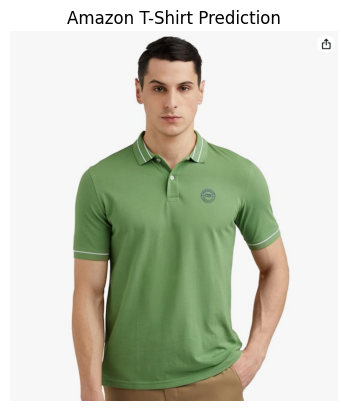


Predicted Labels for Amazon Image:
  - Gender: Men
  - Type: Apparel
  - Season: Fall
  - Color: Green


In [13]:
# Testing on a new Image
amazon_image_path = '/kaggle/input/image-test-1/amazon_image_1.png'

predictions, image = predict_image(amazon_image_path, model, label_mappings)

plt.imshow(image)
plt.title("Amazon T-Shirt Prediction")
plt.axis('off')
plt.show()

print("\nPredicted Labels for Amazon Image:")
print(f"  - Gender: {predictions['gender']}")
print(f"  - Type: {predictions.get('masterCategory', 'N/A')}")
print(f"  - Season: {predictions['season']}")
print(f"  - Color: {predictions.get('baseColour', 'N/A')}")